In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


Training data classes: ['NORMAL', 'PNEUMONIA']
Validation data classes: ['NORMAL', 'PNEUMONIA']
Test data classes: ['NORMAL', 'PNEUMONIA']
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


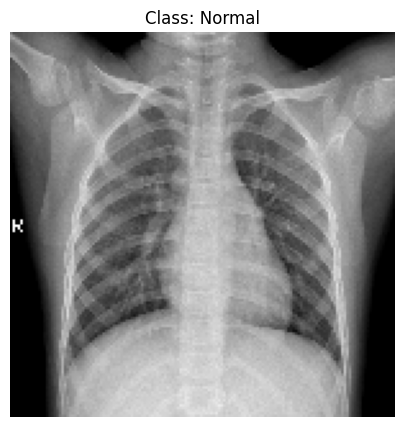

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# Check directories
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

print("Training data classes:", os.listdir(train_dir))
print("Validation data classes:", os.listdir(val_dir))
print("Test data classes:", os.listdir(test_dir))

# Define ImageDataGenerator
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

# Display a sample image
sample_batch, sample_labels = next(train_generator)
plt.figure(figsize=(5,5))
plt.imshow(sample_batch[0])
plt.title(f"Class: {'Pneumonia' if sample_labels[0] == 1 else 'Normal'}")
plt.axis("off")
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Dataset paths
dataset_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Image preprocessing
img_size = (224, 224)  # MobileNetV2 input size
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

# Load MobileNetV2 pre-trained model (without top layers)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Build model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Binary Classification
])

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model (Faster)
history = model.fit(train_generator, validation_data=val_generator, epochs=5, steps_per_epoch=len(train_generator), validation_steps=len(val_generator))

# Evaluate model
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.9065 - loss: 2.2656 - val_accuracy: 0.9375 - val_loss: 0.0987
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.9692 - loss: 0.0904 - val_accuracy: 0.5625 - val_loss: 1.0774
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.9689 - loss: 0.1036 - val_accuracy: 0.8125 - val_loss: 0.3398
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.9772 - loss: 0.0788 - val_accuracy: 1.0000 - val_loss: 0.0847
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9758 - loss: 0.0612 - val_accuracy: 0.6875 - val_loss: 0.6784
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step - accuracy: 0.6875 - loss: 0.6784
Test Accuracy: 68.75%


In [ ]:
# Unfreeze last 20 layers
for layer in model.layers[0].layers[-20:]:
    layer.trainable = True

# Recompile model with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,  # Train longer but with stopping
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.8991 - loss: 1.8182 - val_accuracy: 0.8750 - val_loss: 0.1362 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.9575 - loss: 0.3053 - val_accuracy: 0.8750 - val_loss: 0.3499 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.9745 - loss: 0.2045 - val_accuracy: 0.8750 - val_loss: 0.3923 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9779 - loss: 0.1140 - val_accuracy: 0.8750 - val_loss: 0.3964 - learning_rate: 2.0000e-06


In [ ]:
# Evaluate model on test set
# Create a new test_generator with the correct target_size
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,  # Use img_size from training
    batch_size=batch_size,  # Use batch_size from training
    class_mode="binary",
    shuffle=False  # Important: Set shuffle to False for evaluation
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"🚀 Final Test Accuracy: {test_acc * 100:.2f}%")

Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7467 - loss: 1.7147
🚀 Final Test Accuracy: 84.78%


In [ ]:
#  Load the trained model
# First, save the model if you haven't already:
model.save("pneumonia_mobilenetv2_finetuned.h5")

# Then, load the model
model = tf.keras.models.load_model("pneumonia_mobilenetv2_finetuned.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


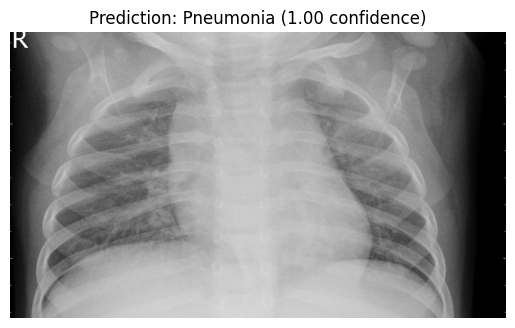

✅ Prediction: Pneumonia
📌 Confidence Score: 1.00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ✅ Load the trained model
model = tf.keras.models.load_model("pneumonia_mobilenetv2_finetuned.h5")

# ✅ Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# ✅ Function to make a prediction and display the result
def predict_image(img_path, model):
    img_array = preprocess_image(img_path)

    prediction = model.predict(img_array)[0][0]
    class_label = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)

    # Display image with prediction
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {class_label} ({confidence:.2f} confidence)")
    plt.axis("off")
    plt.show()

    print(f"✅ Prediction: {class_label}")
    print(f"📌 Confidence Score: {confidence:.2f}")

# ✅ Test with a sample X-ray image (replace with actual path)
test_image_path = "person1947_bacteria_4876.jpeg"  # Change this to an actual X-ray file
predict_image(test_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


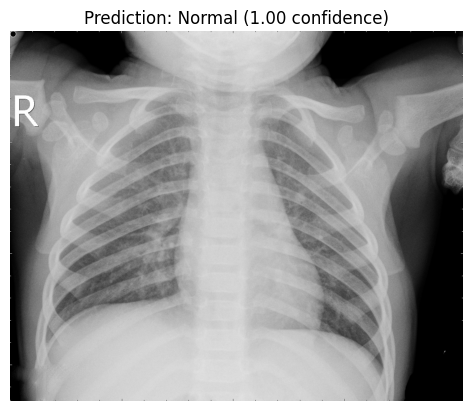

✅ Prediction: Normal
📌 Confidence Score: 1.00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ✅ Load the trained model
model = tf.keras.models.load_model("pneumonia_mobilenetv2_finetuned.h5")

# ✅ Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# ✅ Function to make a prediction and display the result
def predict_image(img_path, model):
    img_array = preprocess_image(img_path)

    prediction = model.predict(img_array)[0][0]
    class_label = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)

    # Display image with prediction
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {class_label} ({confidence:.2f} confidence)")
    plt.axis("off")
    plt.show()

    print(f"✅ Prediction: {class_label}")
    print(f"📌 Confidence Score: {confidence:.2f}")

# ✅ Test with a sample X-ray image (replace with actual path)
test_image_path = "NORMAL2-IM-1430-0001.jpeg"  # Change this to an actual X-ray file
predict_image(test_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


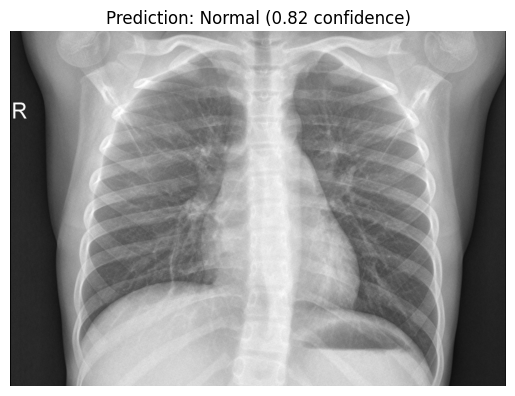

✅ Prediction: Normal
📌 Confidence Score: 0.82


In [ ]:


# ✅ Function to make a prediction and display the result
def predict_image(img_path, model):
    img_array = preprocess_image(img_path)

    prediction = model.predict(img_array)[0][0]
    class_label = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)

    # Display image with prediction
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {class_label} ({confidence:.2f} confidence)")
    plt.axis("off")
    plt.show()

    print(f"✅ Prediction: {class_label}")
    print(f"📌 Confidence Score: {confidence:.2f}")

# ✅ Test with a sample X-ray image (replace with actual path)
test_image_path = "IM-0003-0001.jpeg"  # Change this to an actual X-ray file
predict_image(test_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


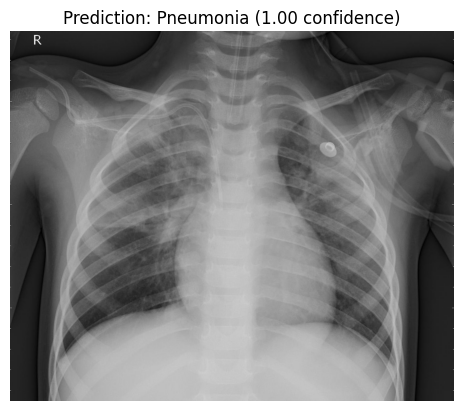

✅ Prediction: Pneumonia
📌 Confidence Score: 1.00


In [ ]:
# ✅ Function to make a prediction and display the result
def predict_image(img_path, model):
    img_array = preprocess_image(img_path)

    prediction = model.predict(img_array)[0][0]
    class_label = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)

    # Display image with prediction
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {class_label} ({confidence:.2f} confidence)")
    plt.axis("off")
    plt.show()

    print(f"✅ Prediction: {class_label}")
    print(f"📌 Confidence Score: {confidence:.2f}")

# ✅ Test with a sample X-ray image (replace with actual path)
test_image_path = "person3_virus_17.jpeg"  # Change this to an actual X-ray file
predict_image(test_image_path, model)